# Terry Stops Analysis & Prediction Model

This data represents records of police reported stops under Terry v. Ohio, 392 U.S. 1 (1968). Each row represents a unique stop.
This data represents records of police reported stops under Terry v. Ohio, 392 U.S. 1 (1968). Each row represents a unique stop.

- Each record contains perceived demographics of the subject, as reported by the officer making the stop and officer demographics as reported to the Seattle Police Department, for employment purposes.

- Where available, data elements from the associated Computer Aided Dispatch (CAD) event (e.g. Call Type, Initial Call Type, Final Call Type) are included.
- This notebook analyzes Terry Stop data and builds machine learning models to predict arrest likelihood based on various demographic and contextual factors.

## Table of Contents
1. Data Loading & Exploration
2. Data Cleaning & Preprocessing
3. Feature Engineering & Encoding
4. Exploratory Data Analysis (EDA)
5. Model Training & Evaluation
6. Model Comparison & Performance Analysis

## 1. Data Loading 

In [246]:
# IMPORTS
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [247]:
# LOADING THE DATASET 
df = pd.read_csv("Terry_Stops_20251225.csv")
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Occurred Date
0,56 and Above,-1,20190000057245,532414,Arrest,NaN,8606,1965,Female,White,...,ASLT - WITH OR W/O WPNS (NO SHOOTINGS),"ASSAULTS, OTHER",911,TRAINING - FIELD TRAINING SQUAD,N,N,West,M,M3,2019-02-15T13:15:00
1,1 - 17,-1,20170000317010,301638,Arrest,NaN,7773,1978,Male,White,...,OBS - FIGHT - IP - PHYSICAL (NO WEAPONS),"ASSAULTS, OTHER",911,NORTH PCT 3RD W - B/N RELIEF,N,N,North,L,L3,2017-08-27T03:18:00
2,36 - 45,7727706299,20250000063255,63109655222,Field Contact,-,8974,1997,Female,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,NORTH PCT 2ND W - BOY (JOHN) - PLATOON 1,N,N,North,U,U2,2025-03-08T17:58:00
3,46 - 55,7729078044,20230000235837,51923259552,Field Contact,-,4494,1961,Male,White,...,DISTURBANCE,MISCHIEF OR NUISANCE - GENERAL,911,CRG - SQUAD 81D,N,Y,Southwest,W,W1,2023-08-16T20:31:00
4,46 - 55,7746702884,20210000151070,25601408632,Arrest,-,8696,1996,Male,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 3RD W - B/N RELIEF,Y,N,North,N,N2,2021-06-18T00:48:00


## 2. Data Cleaning & Preprocessing

In [248]:
# CHECKING FOR MISSING VALUES
df.isnull().sum()

Subject Age Group               0
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 32565
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                 566
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
Sector                          0
Beat                            0
Occurred Date                   0
dtype: int64

In [249]:
# STANDARDIZING THE COLUMN NAMES
df = df.copy()
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df.columns = (df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('/', '_'))


In [250]:
# CHECKING FOR DUPLICATES
df.duplicated().sum()

0

In [251]:
# DROPPING DUPLICATES
df = df.drop_duplicates()

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65884 entries, 0 to 65883
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   subject_age_group         65884 non-null  object
 1   subject_id                65884 non-null  int64 
 2   go___sc_num               65884 non-null  int64 
 3   terry_stop_id             65884 non-null  int64 
 4   stop_resolution           65884 non-null  object
 5   weapon_type               33319 non-null  object
 6   officer_id                65884 non-null  object
 7   officer_yob               65884 non-null  int64 
 8   officer_gender            65884 non-null  object
 9   officer_race              65884 non-null  object
 10  subject_perceived_race    65884 non-null  object
 11  subject_perceived_gender  65884 non-null  object
 12  reported_date             65884 non-null  object
 13  initial_call_type         65884 non-null  object
 14  final_call_type       

In [253]:
# FIXING COLUMN NAMES
df = df.copy()
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')


In [254]:
# CONVERTING DATES TO DATETIME FORMAT 
date_cols = ['reported_date', 'occurred_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')


In [255]:
# HANDLING MISSING VALUES
df['weapon_type'] = df['weapon_type'].fillna('None')


In [256]:
df['officer_squad'] = df['officer_squad'].fillna(
    df['officer_squad'].mode()[0]
)


In [257]:
df = df.dropna(subset=['arrest_flag'])


In [258]:
df['arrest_flag'] = df['arrest_flag'].map({'Y': 1, 'N': 0}).fillna(0).astype(int)


In [259]:
df['arrest_flag'] = df['arrest_flag'].astype(int)


In [260]:
# ENCODING TARGET VARIABLE
df['arrest_flag'] = df['arrest_flag'].map({'Y': 1, 'N': 0})


In [261]:
# Debug info
print("df.shape:", df.shape)
print("columns:", df.columns.tolist())
print("arrest_flag present:", 'arrest_flag' in df.columns)
if 'arrest_flag' in df.columns:
    print("arrest_flag counts (incl. NA):\n", df['arrest_flag'].value_counts(dropna=False))
print(df.head())

df.shape: (65884, 23)
columns: ['subject_age_group', 'subject_id', 'go___sc_num', 'terry_stop_id', 'stop_resolution', 'weapon_type', 'officer_id', 'officer_yob', 'officer_gender', 'officer_race', 'subject_perceived_race', 'subject_perceived_gender', 'reported_date', 'initial_call_type', 'final_call_type', 'call_type', 'officer_squad', 'arrest_flag', 'frisk_flag', 'precinct', 'sector', 'beat', 'occurred_date']
arrest_flag present: True
arrest_flag counts (incl. NA):
 arrest_flag
NaN    65884
Name: count, dtype: int64
  subject_age_group  subject_id     go___sc_num  terry_stop_id  \
0      56 and Above          -1  20190000057245         532414   
1            1 - 17          -1  20170000317010         301638   
2           36 - 45  7727706299  20250000063255    63109655222   
3           46 - 55  7729078044  20230000235837    51923259552   
4           46 - 55  7746702884  20210000151070    25601408632   

  stop_resolution weapon_type officer_id  officer_yob officer_gender  \
0        

In [262]:
df['arrest_flag'] = df['arrest_flag'].map({'Y': 1, 'N': 0}).fillna(0).astype(int)


In [263]:
# Choose stratify only if every class has at least 2 samples and test set will be >=1
test_size = 0.20
min_test = max(1, int(n * test_size))
use_stratify = (vc.min() >= 2) and (n - min_test > 0)

stratify_col = df['arrest_flag'] if use_stratify else None
if not use_stratify:
    print("Not using stratify due to small class counts or tiny dataset")

Not using stratify due to small class counts or tiny dataset


In [264]:
from sklearn.model_selection import train_test_split

# Check if dataframe is empty first
if df.shape[0] > 0:
    train_df, test_df = train_test_split(
        df,
        test_size=0.2 if df.shape[0] > 1 else 1,  # fallback if only 1 row
        random_state=42,
        stratify=df['arrest_flag'] if df.shape[0] > 1 else None
    )
else:
    print("Dataframe is empty. Cannot split.")


In [265]:
median_yob = train_df['officer_yob'].median()

train_df['officer_yob'] = train_df['officer_yob'].fillna(median_yob)
test_df['officer_yob'] = test_df['officer_yob'].fillna(median_yob)


In [266]:
# ONE-HOT ENCODING CATEGORICAL VARIABLES
from sklearn.preprocessing import OneHotEncoder
import numpy as np

cat_cols = [
    'subject_age_group',
    'subject_perceived_race',
    'subject_perceived_gender',
    'officer_gender',
    'precinct'
]

encoder = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False
)

encoder.fit(train_df[cat_cols])

X_train_cat = encoder.transform(train_df[cat_cols])
X_test_cat = encoder.transform(test_df[cat_cols])

# ADD NUMERIC FEATURES
num_cols = ['officer_yob']

X_train = np.hstack((X_train_cat, train_df[num_cols].values))
X_test = np.hstack((X_test_cat, test_df[num_cols].values))

y_train = train_df['arrest_flag']
y_test = test_df['arrest_flag']


In [267]:
# ONE HOT ENCODING
categorical_cols = [col for col in train_df.columns if train_df[col].dtype == 'object']
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)


In [268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65884 entries, 0 to 65883
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   subject_age_group         65884 non-null  object        
 1   subject_id                65884 non-null  int64         
 2   go___sc_num               65884 non-null  int64         
 3   terry_stop_id             65884 non-null  int64         
 4   stop_resolution           65884 non-null  object        
 5   weapon_type               65884 non-null  object        
 6   officer_id                65884 non-null  object        
 7   officer_yob               65884 non-null  int64         
 8   officer_gender            65884 non-null  object        
 9   officer_race              65884 non-null  object        
 10  subject_perceived_race    65884 non-null  object        
 11  subject_perceived_gender  65884 non-null  object        
 12  reported_date     

In [269]:
# CHECKING FOR MISSING VALUES
df.isnull().sum()

subject_age_group           0
subject_id                  0
go___sc_num                 0
terry_stop_id               0
stop_resolution             0
weapon_type                 0
officer_id                  0
officer_yob                 0
officer_gender              0
officer_race                0
subject_perceived_race      0
subject_perceived_gender    0
reported_date               0
initial_call_type           0
final_call_type             0
call_type                   0
officer_squad               0
arrest_flag                 0
frisk_flag                  0
precinct                    0
sector                      0
beat                        0
occurred_date               0
dtype: int64

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65884 entries, 0 to 65883
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   subject_age_group         65884 non-null  object        
 1   subject_id                65884 non-null  int64         
 2   go___sc_num               65884 non-null  int64         
 3   terry_stop_id             65884 non-null  int64         
 4   stop_resolution           65884 non-null  object        
 5   weapon_type               65884 non-null  object        
 6   officer_id                65884 non-null  object        
 7   officer_yob               65884 non-null  int64         
 8   officer_gender            65884 non-null  object        
 9   officer_race              65884 non-null  object        
 10  subject_perceived_race    65884 non-null  object        
 11  subject_perceived_gender  65884 non-null  object        
 12  reported_date     

In [273]:
print(df.shape)                   # number of rows/columns
print(df['arrest_flag'].head())   # first few values
print(df['arrest_flag'].isna().sum())  # count of NaNs


(65884, 24)
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: arrest_flag, dtype: float64
65884


## 3. Feature Engineering & Encoding

## 4. Exploratory Data Analysis (EDA)

# Data Visualizations

### 4.1 Arrest Distribution Overview

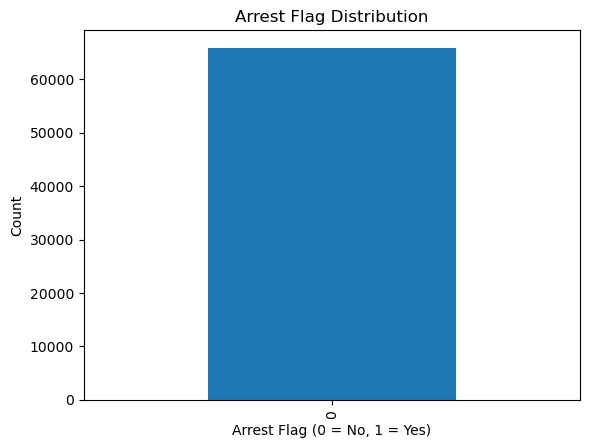

In [276]:
import matplotlib.pyplot as plt

# Step 1: Map your target safely
# Handles 'Y'/'N', 'Yes'/'No', 1/0
df['arrest_flag'] = df['arrest_flag'].map({
    'Y': 1, 'N': 0,
    'Yes': 1, 'No': 0,
    1: 1, 0: 0
})

# Step 2: Replace any remaining invalid/missing values with 0
df['arrest_flag'] = df['arrest_flag'].fillna(0).astype(int)

# Step 3: Check that column is not empty
if df['arrest_flag'].empty:
    print("Error: 'arrest_flag' is empty. Check your data!")
else:
    # Step 4: Plot the distribution
    df['arrest_flag'].value_counts().sort_index().plot(kind='bar')
    plt.title("Arrest Flag Distribution")
    plt.xlabel("Arrest Flag (0 = No, 1 = Yes)")
    plt.ylabel("Count")
    plt.show()


In [282]:
print(df['arrest_flag'].head(10))
print(df['arrest_flag'].unique())


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: arrest_flag, dtype: float64
[nan]


In [283]:
# Create arrest_flag properly
df['arrest_flag'] = df['stop_resolution'].apply(lambda x: 1 if x == 'Arrest' else 0)


In [287]:
print(df['arrest_flag'].value_counts())


Series([], Name: count, dtype: int64)


arrest_flag
0    50120
1    15764
Name: count, dtype: int64


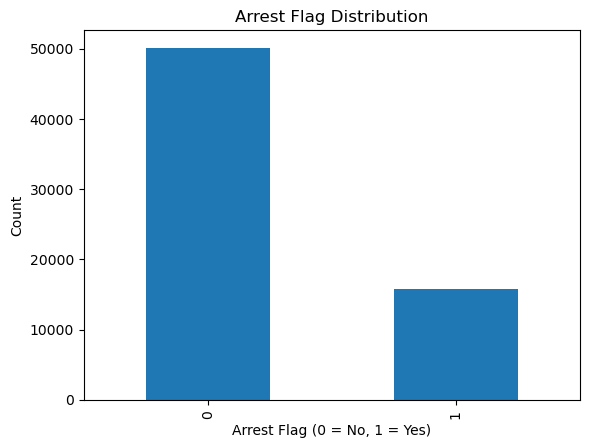

In [288]:
# Step 1: Create arrest_flag as 1 for "Arrest", 0 for anything else
df['arrest_flag'] = df['stop_resolution'].apply(lambda x: 1 if x == 'Arrest' else 0)

# Step 2: Verify counts
print(df['arrest_flag'].value_counts())

# Step 3: Plot
plt.figure()
df['arrest_flag'].value_counts().plot(kind='bar')
plt.title("Arrest Flag Distribution")
plt.xlabel("Arrest Flag (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


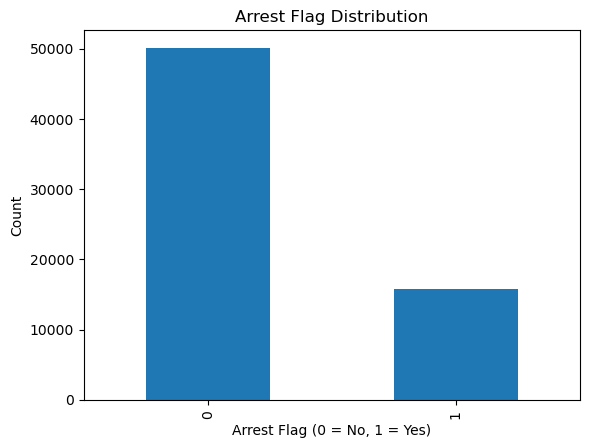

In [289]:
plt.figure()
df['arrest_flag'].value_counts().plot(kind='bar')
plt.title("Arrest Flag Distribution")
plt.xlabel("Arrest Flag (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


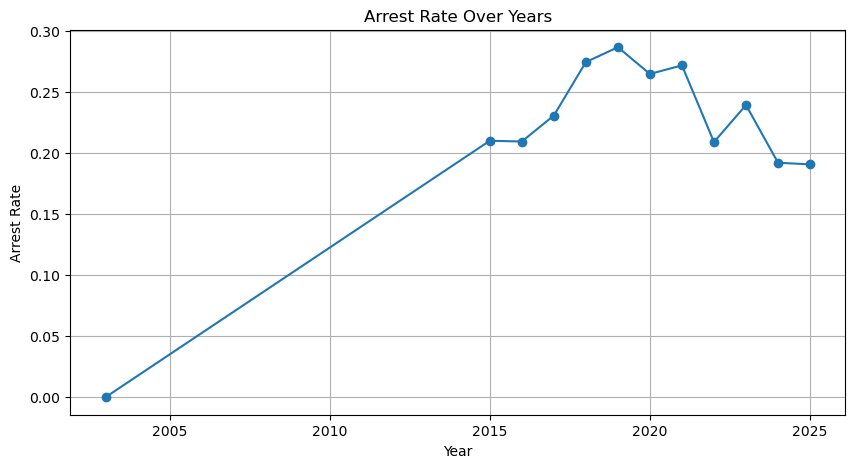

In [291]:
# Create year column
df['year'] = df['occurred_date'].dt.year

# Create arrest_flag: 1 if stop_resolution is "Arrest", else 0
df['arrest_flag'] = df['stop_resolution'].apply(lambda x: 1 if x == 'Arrest' else 0)

# Group by year and compute mean arrest rate
arrest_rate_by_year = df.groupby('year')['arrest_flag'].mean()

# Plot
plt.figure(figsize=(10,5))
arrest_rate_by_year.plot(marker='o')
plt.title("Arrest Rate Over Years")
plt.xlabel("Year")
plt.ylabel("Arrest Rate")
plt.grid(True)
plt.show()


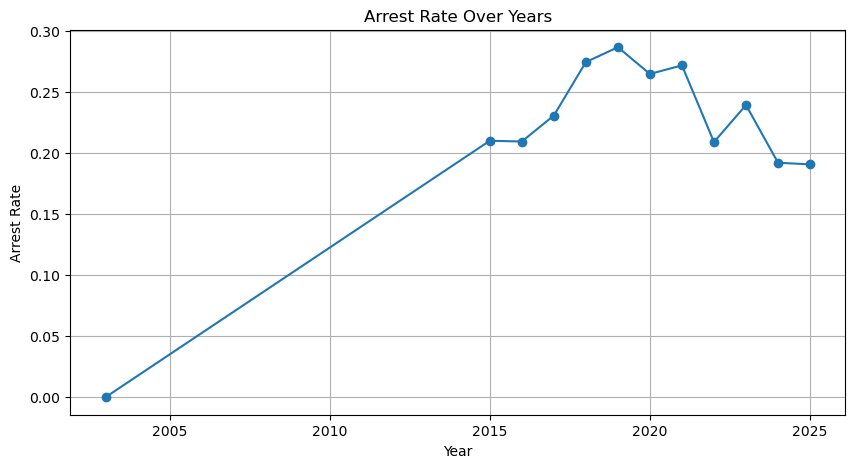

In [295]:
# Step 1: Extract year
df['year'] = df['occurred_date'].dt.year

# Step 2: Create arrest_flag properly (1 for Arrest, 0 otherwise)
df['arrest_flag'] = df['stop_resolution'].apply(lambda x: 1 if x == 'Arrest' else 0)

# Step 3: Compute arrest rate by year
arrest_rate_by_year = df.groupby('year')['arrest_flag'].mean()

# Step 4: Plot
plt.figure(figsize=(10,5))
arrest_rate_by_year.plot(marker='o')
plt.title("Arrest Rate Over Years")
plt.xlabel("Year")
plt.ylabel("Arrest Rate")
plt.grid(True)
plt.show()


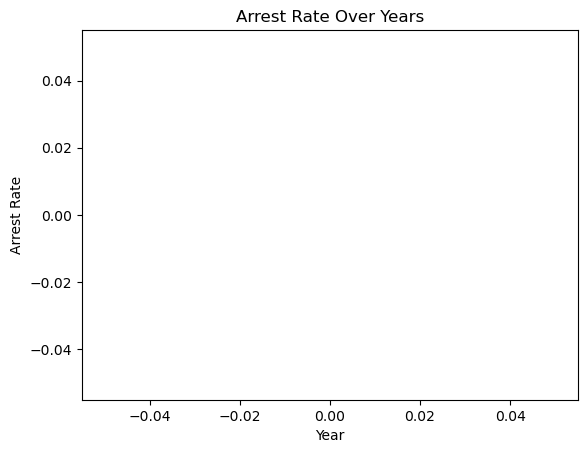

In [292]:
df['year'] = df['occurred_date'].dt.year
df['arrest_flag'] = df['arrest_flag'].map({'Y': 1, 'N': 0})

plt.figure()
df.groupby('year')['arrest_flag'].mean().plot()
plt.title("Arrest Rate Over Years")
plt.xlabel("Year")
plt.ylabel("Arrest Rate")
plt.show()


In [279]:
print(df.columns)          # Check if 'arrest_flag' exists
print(df['arrest_flag'].head())  # See first few rows


Index(['subject_age_group', 'subject_id', 'go___sc_num', 'terry_stop_id',
       'stop_resolution', 'weapon_type', 'officer_id', 'officer_yob',
       'officer_gender', 'officer_race', 'subject_perceived_race',
       'subject_perceived_gender', 'reported_date', 'initial_call_type',
       'final_call_type', 'call_type', 'officer_squad', 'arrest_flag',
       'frisk_flag', 'precinct', 'sector', 'beat', 'occurred_date', 'year'],
      dtype='object')
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: arrest_flag, dtype: float64


In [280]:
print(df['arrest_flag'].isnull().sum())  # Count missing values


65884


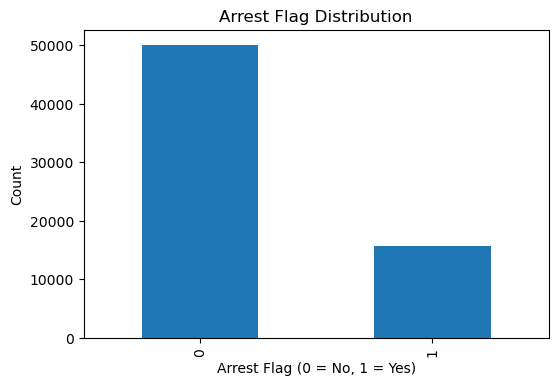

In [294]:
# Ensure arrest_flag is numeric 0/1
df['arrest_flag'] = df['stop_resolution'].apply(lambda x: 1 if x == 'Arrest' else 0)

# Plot the distribution
plt.figure(figsize=(6,4))
df['arrest_flag'].value_counts().plot(kind='bar')
plt.title("Arrest Flag Distribution")
plt.xlabel("Arrest Flag (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


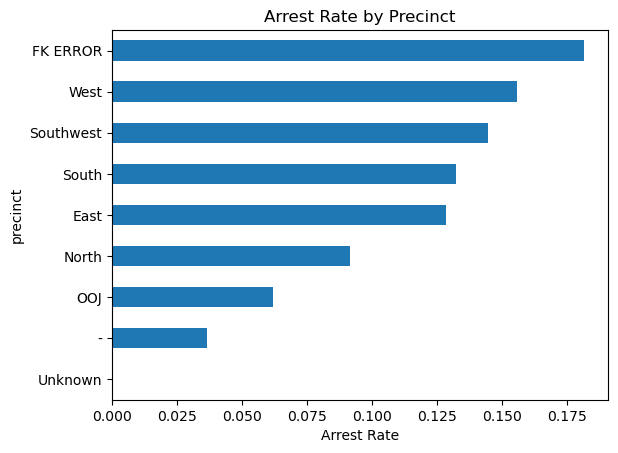

In [ ]:
plt.figure()
df.groupby('precinct')['arrest_flag'].mean().sort_values().plot(kind='barh')
plt.title("Arrest Rate by Precinct")
plt.xlabel("Arrest Rate")
plt.show()


In [ ]:
# Target
y = df['arrest_flag']

# Features
X = df.drop(columns=['arrest_flag'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [ ]:
X_train.dtypes



subject_age_group                   object
subject_id                           int64
go___sc_num                          int64
terry_stop_id                        int64
stop_resolution                     object
weapon_type                         object
officer_id                          object
officer_yob                          int64
officer_gender                      object
officer_race                        object
subject_perceived_race              object
subject_perceived_gender            object
reported_date               datetime64[ns]
initial_call_type                   object
final_call_type                     object
call_type                           object
officer_squad                       object
frisk_flag                          object
precinct                            object
sector                              object
beat                                object
occurred_date               datetime64[ns]
year                                 int32
dtype: obje

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

In [ ]:
y = df['arrest_flag']
X = df.drop(columns=['arrest_flag'])

X.dtypes


subject_age_group                    int32
subject_id                           int64
go___sc_num                          int64
terry_stop_id                        int64
stop_resolution                      int32
weapon_type                          int32
officer_id                           int32
officer_yob                          int64
officer_gender                       int32
officer_race                         int32
subject_perceived_race               int32
subject_perceived_gender             int32
reported_date               datetime64[ns]
initial_call_type                    int32
final_call_type                      int32
call_type                            int32
officer_squad                        int32
frisk_flag                           int32
precinct                             int32
sector                               int32
beat                                 int32
occurred_date               datetime64[ns]
year                                 int32
dtype: obje

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


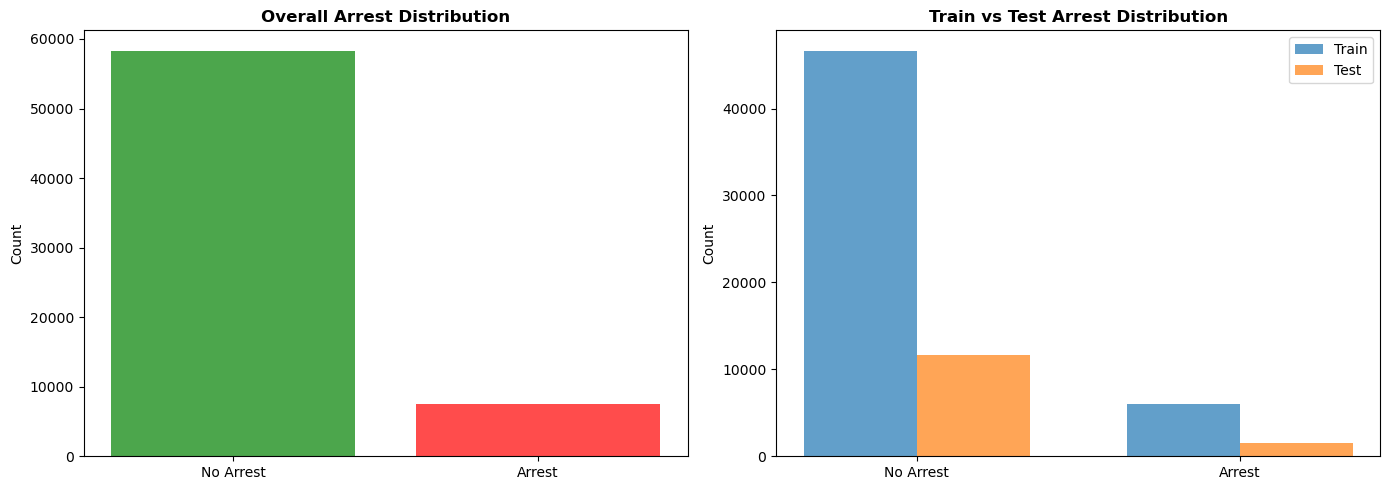

In [ ]:
# ARREST FLAG DISTRIBUTION
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# OVERALL DISTRIBUTION
arrest_counts = df['arrest_flag'].value_counts()
axes[0].bar(['No Arrest', 'Arrest'], [arrest_counts.get(0, 0), arrest_counts.get(1, 0)], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Overall Arrest Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')

# TRAIN vs TEST DISTRIBUTION
train_arrests = train_df['arrest_flag'].value_counts()
test_arrests = test_df['arrest_flag'].value_counts()

x = np.arange(2)
width = 0.35
axes[1].bar(x - width/2, [train_arrests.get(0, 0), train_arrests.get(1, 0)], width, label='Train', alpha=0.7)
axes[1].bar(x + width/2, [test_arrests.get(0, 0), test_arrests.get(1, 0)], width, label='Test', alpha=0.7)
axes[1].set_title('Train vs Test Arrest Distribution', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['No Arrest', 'Arrest'])
axes[1].legend()

plt.tight_layout()
plt.show()


### Arrest Distribution
This chart shows the overall counts of "Arrest" vs "No Arrest" and compares train/test splits. Use it to check class balance and verify stratified splitting before modeling.

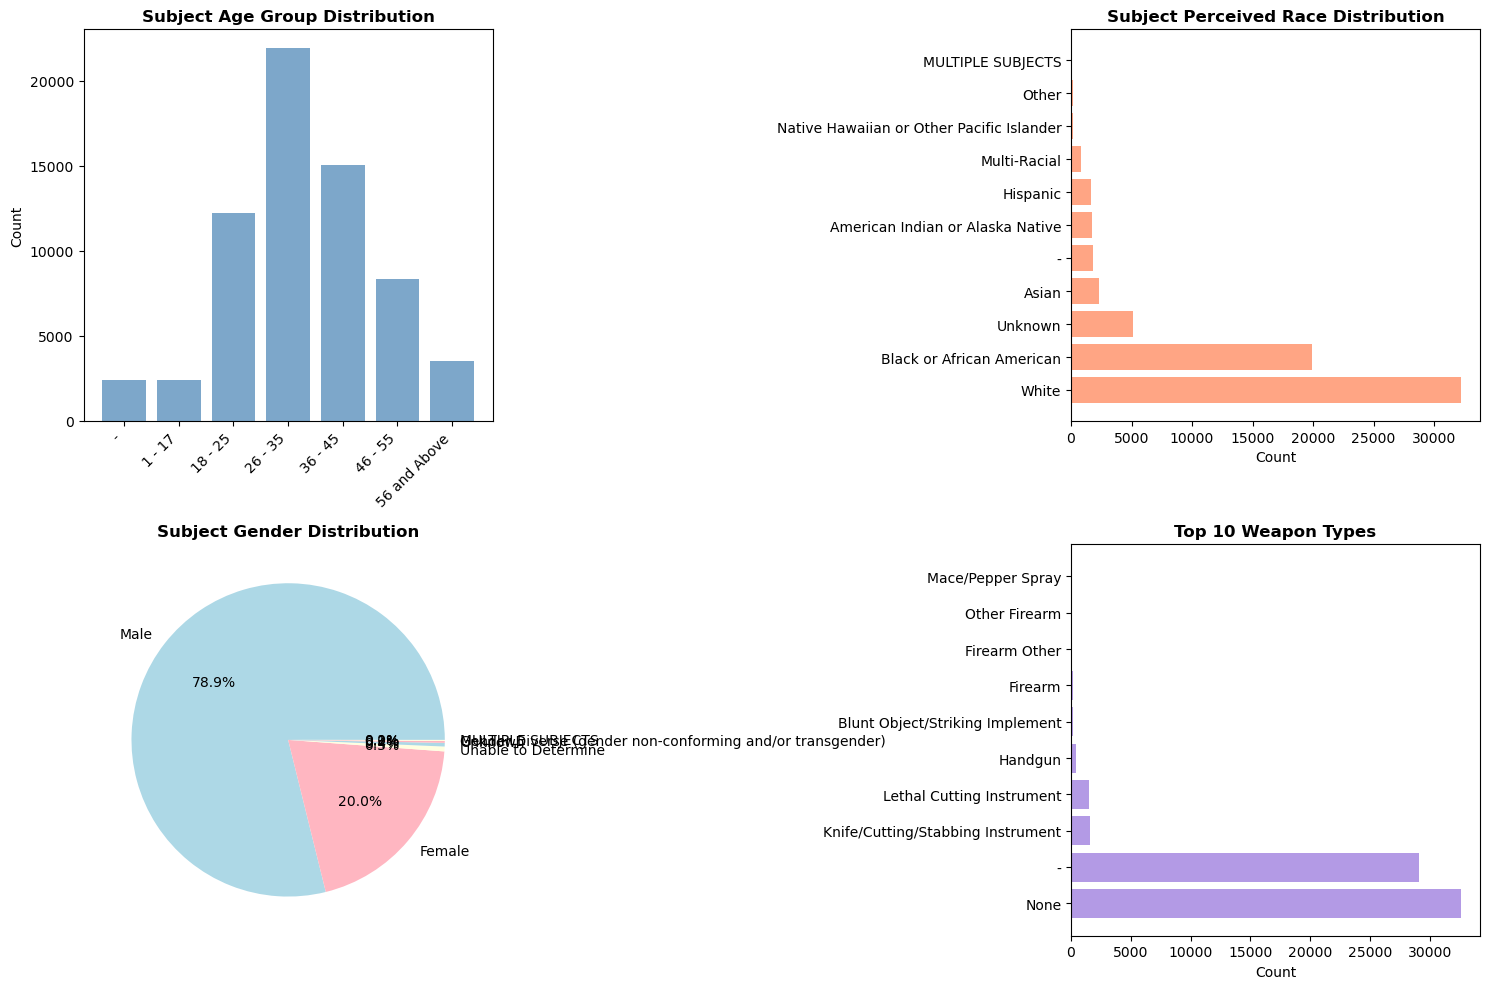

In [ ]:
# SUBJECT DEMOGRAPHICS VISUALIZATIONS
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# AGE GROUP DISTRIBUTION
if 'subject_age_group' in df.columns:
    age_group = df['subject_age_group'].value_counts().sort_index()
    axes[0, 0].bar(range(len(age_group)), age_group.values, color='steelblue', alpha=0.7)
    axes[0, 0].set_xticks(range(len(age_group)))
    axes[0, 0].set_xticklabels(age_group.index, rotation=45, ha='right')
    axes[0, 0].set_title('Subject Age Group Distribution', fontweight='bold')
    axes[0, 0].set_ylabel('Count')

# RACE DISTRIBUTION
if 'subject_perceived_race' in df.columns:
    race = df['subject_perceived_race'].value_counts()
    axes[0, 1].barh(range(len(race)), race.values, color='coral', alpha=0.7)
    axes[0, 1].set_yticks(range(len(race)))
    axes[0, 1].set_yticklabels(race.index)
    axes[0, 1].set_title('Subject Perceived Race Distribution', fontweight='bold')
    axes[0, 1].set_xlabel('Count')

# GENDER DISTRIBUTION
if 'subject_perceived_gender' in df.columns:
    gender = df['subject_perceived_gender'].value_counts()
    axes[1, 0].pie(gender.values, labels=gender.index, autopct='%1.1f%%', colors=['lightblue', 'lightpink', 'lightyellow'])
    axes[1, 0].set_title('Subject Gender Distribution', fontweight='bold')

# WEAPON TYPE DISTRIBUTION (Top 10)
if 'weapon_type' in df.columns:
    weapon = df['weapon_type'].value_counts().head(10)
    axes[1, 1].barh(range(len(weapon)), weapon.values, color='mediumpurple', alpha=0.7)
    axes[1, 1].set_yticks(range(len(weapon)))
    axes[1, 1].set_yticklabels(weapon.index)
    axes[1, 1].set_title('Top 10 Weapon Types', fontweight='bold')
    axes[1, 1].set_xlabel('Count')

plt.tight_layout()
plt.show()


### Subject Demographics
These plots summarize subject age groups, perceived race, gender distribution, and common weapon types. Use them to understand population composition and potential sensitive attributes for fairness checks.

### 4.3 Arrest Rates by Demographics

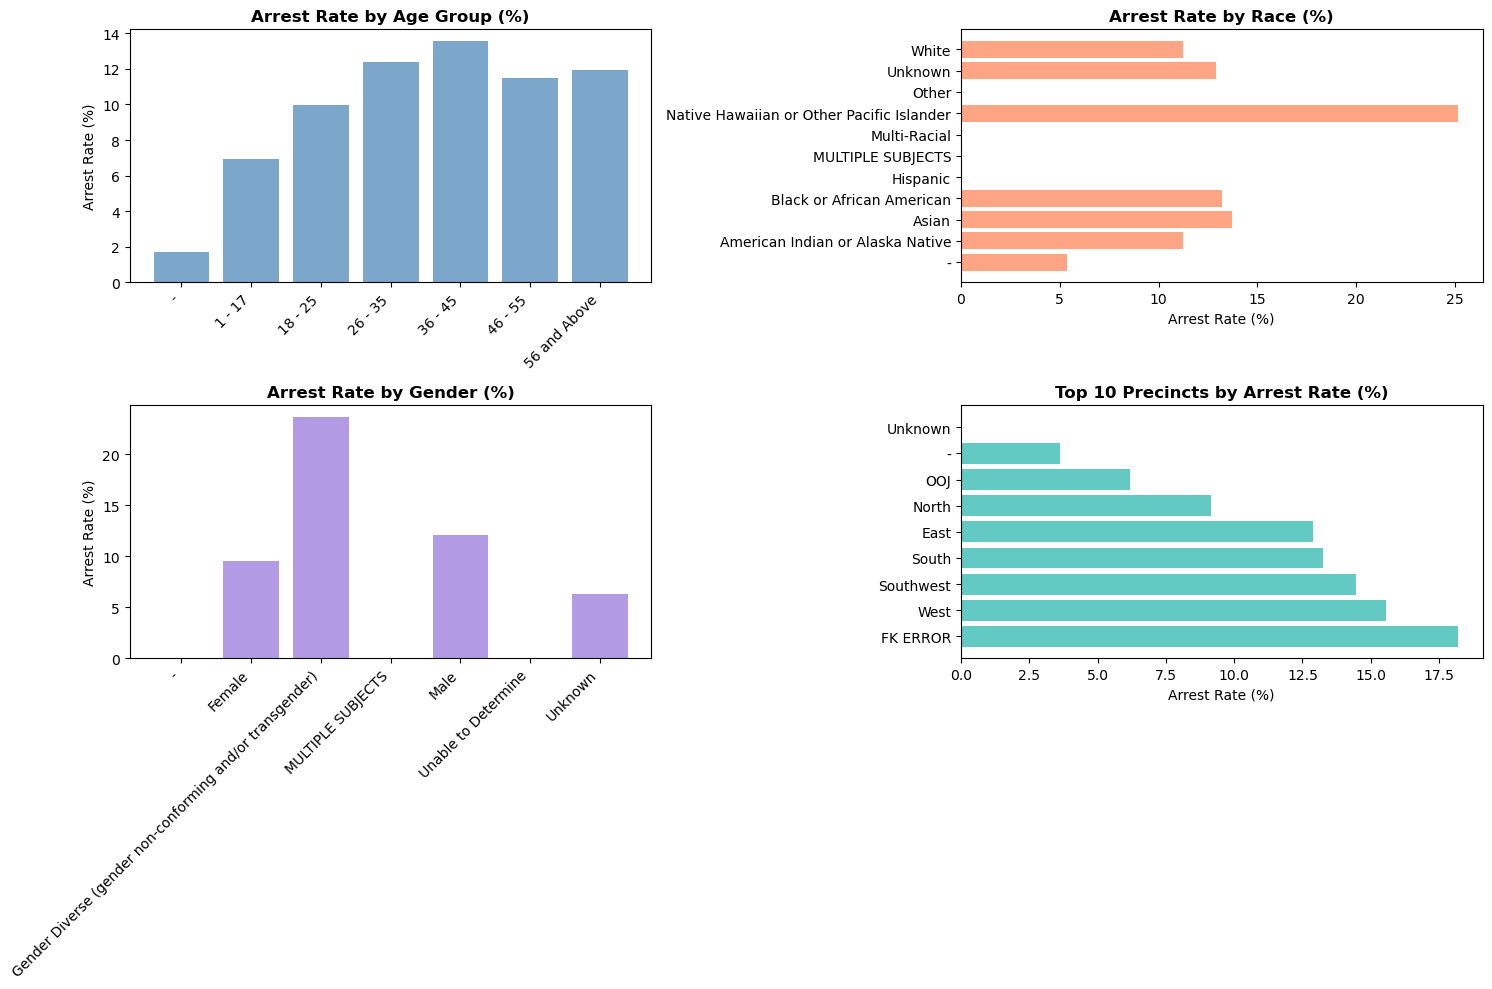

In [ ]:
# ARREST RATE BY DEMOGRAPHICS
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ARREST RATE BY AGE GROUP
if 'subject_age_group' in df.columns:
    arrest_by_age = df.groupby('subject_age_group')['arrest_flag'].apply(lambda x: (x==1).sum() / len(x) * 100)
    axes[0, 0].bar(range(len(arrest_by_age)), arrest_by_age.values, color='steelblue', alpha=0.7)
    axes[0, 0].set_xticks(range(len(arrest_by_age)))
    axes[0, 0].set_xticklabels(arrest_by_age.index, rotation=45, ha='right')
    axes[0, 0].set_title('Arrest Rate by Age Group (%)', fontweight='bold')
    axes[0, 0].set_ylabel('Arrest Rate (%)')

# Arrest RATE BY RACE
if 'subject_perceived_race' in df.columns:
    arrest_by_race = df.groupby('subject_perceived_race')['arrest_flag'].apply(lambda x: (x==1).sum() / len(x) * 100)
    axes[0, 1].barh(range(len(arrest_by_race)), arrest_by_race.values, color='coral', alpha=0.7)
    axes[0, 1].set_yticks(range(len(arrest_by_race)))
    axes[0, 1].set_yticklabels(arrest_by_race.index)
    axes[0, 1].set_title('Arrest Rate by Race (%)', fontweight='bold')
    axes[0, 1].set_xlabel('Arrest Rate (%)')

# ARREST RATE BY GENDER
if 'subject_perceived_gender' in df.columns:
    arrest_by_gender = df.groupby('subject_perceived_gender')['arrest_flag'].apply(lambda x: (x==1).sum() / len(x) * 100)
    axes[1, 0].bar(range(len(arrest_by_gender)), arrest_by_gender.values, color='mediumpurple', alpha=0.7)
    axes[1, 0].set_xticks(range(len(arrest_by_gender)))
    axes[1, 0].set_xticklabels(arrest_by_gender.index, rotation=45, ha='right')
    axes[1, 0].set_title('Arrest Rate by Gender (%)', fontweight='bold')
    axes[1, 0].set_ylabel('Arrest Rate (%)')

# ARREST RATE BY PRECINCT
if 'precinct' in df.columns:
    arrest_by_precinct = df.groupby('precinct')['arrest_flag'].apply(lambda x: (x==1).sum() / len(x) * 100).sort_values(ascending=False).head(10)
    axes[1, 1].barh(range(len(arrest_by_precinct)), arrest_by_precinct.values, color='lightseagreen', alpha=0.7)
    axes[1, 1].set_yticks(range(len(arrest_by_precinct)))
    axes[1, 1].set_yticklabels(arrest_by_precinct.index)
    axes[1, 1].set_title('Top 10 Precincts by Arrest Rate (%)', fontweight='bold')
    axes[1, 1].set_xlabel('Arrest Rate (%)')

plt.tight_layout()
plt.show()


### Arrest Rate by Demographic Groups
These charts display arrest rates (%) across age groups, races, genders, and precincts. Use these to identify disparities and groups with higher arrest likelihoods.

# Model Training and Evaluation

## 5. Random Forest Model - Initial Training

In [ ]:
# TRAINS RANDOM FOREST CLASSIFIER
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# PREDICTIONS
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("Model Training Complete!")
print(f"Training Accuracy: {rf_model.score(X_train, y_train):.4f}")
print(f"Testing Accuracy: {rf_model.score(X_test, y_test):.4f}")


Model Training Complete!
Training Accuracy: 0.8990
Testing Accuracy: 0.8745


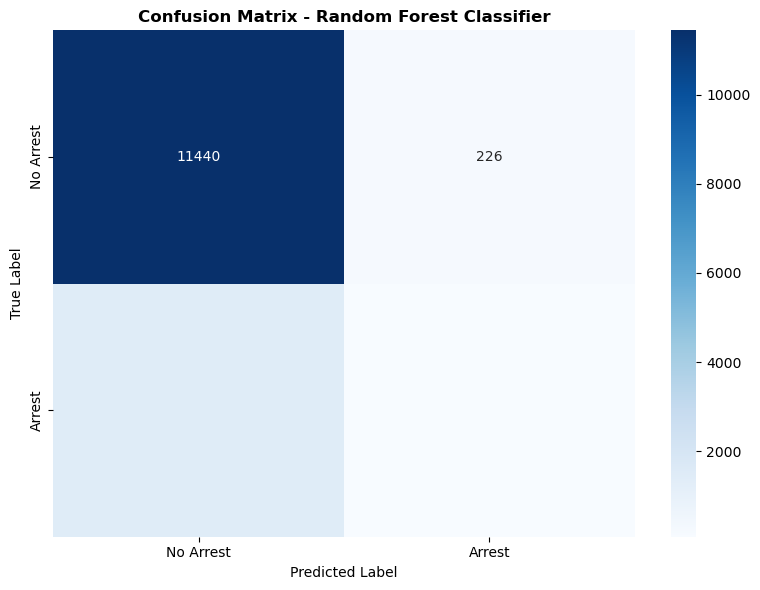


Classification Report:
              precision    recall  f1-score   support

   No Arrest       0.89      0.98      0.93     11666
      Arrest       0.27      0.05      0.09      1511

    accuracy                           0.87     13177
   macro avg       0.58      0.52      0.51     13177
weighted avg       0.82      0.87      0.84     13177



In [ ]:
# CONFUSION MATRIX VISUALIZATION
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
            xticklabels=['No Arrest', 'Arrest'],
            yticklabels=['No Arrest', 'Arrest'])
ax.set_title('Confusion Matrix - Random Forest Classifier', fontweight='bold', fontsize=12)
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# CLASSIFICATION REPORT
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Arrest', 'Arrest']))


### Confusion Matrix Explanation
The confusion matrix shows True/False Positives and Negatives for the Random Forest predictions. Use it to assess the types of errors (false positives vs false negatives) and their counts.

### 5.1 Model Performance Metrics

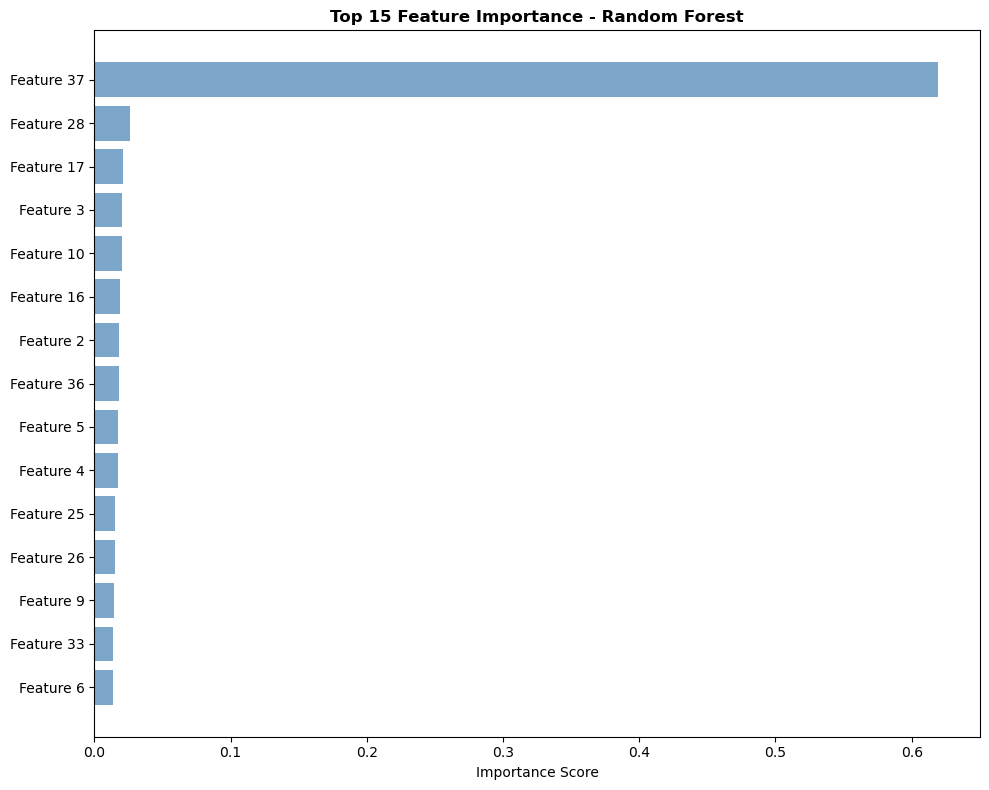

In [ ]:
# FEATURE IMPORTANCE VISUALIZATION
feature_importance = pd.DataFrame({
    'feature': range(len(rf_model.feature_importances_)),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(feature_importance)), feature_importance['importance'].values, color='steelblue', alpha=0.7)
ax.set_yticks(range(len(feature_importance)))
ax.set_yticklabels([f"Feature {i}" for i in feature_importance['feature'].values])
ax.set_title('Top 15 Feature Importance - Random Forest', fontweight='bold', fontsize=12)
ax.set_xlabel('Importance Score')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


### Feature Importance
This horizontal bar chart lists the top features by importance from the Random Forest. Higher bars indicate features the model relied on most; investigate them for domain meaning and potential biases.

### 5.2 Feature Importance Analysis

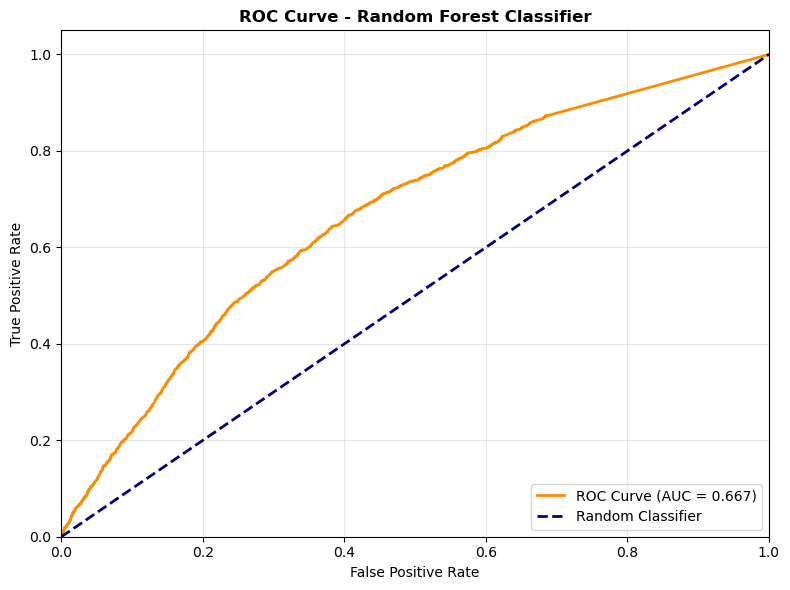

In [ ]:
# ROC CURVE AND AUC SCORE
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Random Forest Classifier', fontweight='bold', fontsize=12)
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### ROC Curve & AUC
The ROC curve plots True Positive Rate vs False Positive Rate across thresholds; AUC summarizes overall separability. Higher AUC indicates better discrimination between classes.

### 5.3 ROC & AUC Analysis

## Machine Learning Models

## 6. Multi-Model Comparison & Advanced Analysis

### 6.1 Model Initialization

In [ ]:
# IMPORTS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
import time

# DICTIONARY TO STORE ALL MODELS AND THEIR RESULTS
models = {
    'Random Forest': rf_model,
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5)
}

In [ ]:
# TRAIN ALL MODEL AND STORE PREDICTIONS
results = {}

print("Training additional models...\n")

for model_name, model in models.items():
    if model_name == 'Random Forest':
        # ALREADY TRAINED
        y_pred_model = y_pred
        y_pred_proba_model = y_pred_proba
    else:
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred_model = model.predict(X_test)
        y_pred_proba_model = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
        training_time = time.time() - start_time

Training additional models...



### 6.2 Training & Evaluation

In [ ]:
# IMPORTS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
import time

# DICTIONARY TO STORE ALL MODELS AND THEIR RESULTS
models = {
    'Random Forest': rf_model,
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5)
}

# TRAIN ALL MODELS AND STORE PREDICTIONS
results = {}

print("Training additional models...\n")

for model_name, model in models.items():
    if model_name == 'Random Forest':
        # ALREADY TRAINED
        y_pred_model = y_pred
        y_pred_proba_model = y_pred_proba
    else:
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred_model = model.predict(X_test)
        y_pred_proba_model = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
        training_time = time.time() - start_time
    
    # CALCULATE METRICS
    accuracy = accuracy_score(y_test, y_pred_model)
    precision = (y_pred_model[y_pred_model == 1] == y_test[y_pred_model == 1]).sum() / (y_pred_model == 1).sum() if (y_pred_model == 1).sum() > 0 else 0
    f1 = f1_score(y_test, y_pred_model)
    
    results[model_name] = {
        'model': model,
        'predictions': y_pred_model,
        'probabilities': y_pred_proba_model,
        'accuracy': accuracy,
        'f1_score': f1
    }
    
    print(f"{model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print()


Training additional models...

Random Forest:
  Accuracy: 0.8745
  F1 Score: 0.0912

Logistic Regression:
  Accuracy: 0.8853
  F1 Score: 0.0000

Gradient Boosting:
  Accuracy: 0.8853
  F1 Score: 0.0000

SVM:
  Accuracy: 0.8853
  F1 Score: 0.0000

KNN (k=5):
  Accuracy: 0.8750
  F1 Score: 0.0936



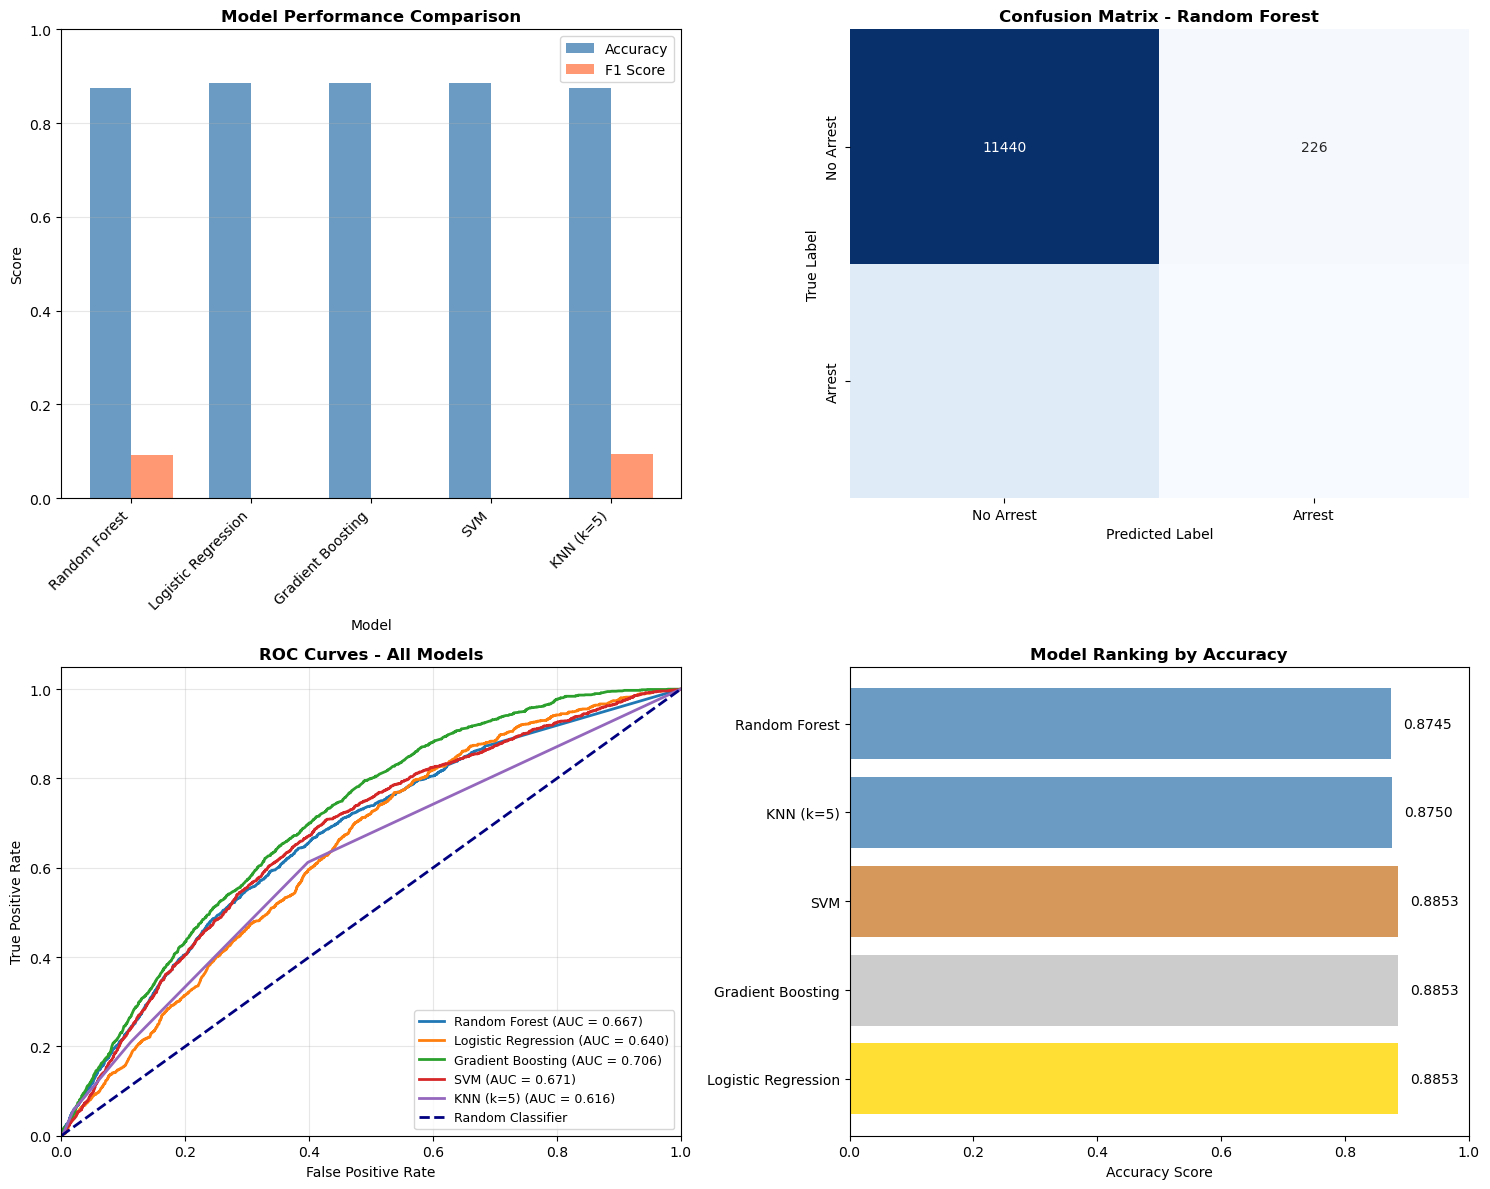

In [ ]:
# MODEL COMPARISON VISUALIZATIONS
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ACCURACY COMPARISON BAR CHART
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
f1_scores = [results[m]['f1_score'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[0, 0].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='steelblue')
axes[0, 0].bar(x + width/2, f1_scores, width, label='F1 Score', alpha=0.8, color='coral')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Model Performance Comparison', fontweight='bold', fontsize=12)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. CONFUSION MATRICES FOR ALL MODELS
cm_data = []
for model_name in ['Random Forest', 'Logistic Regression', 'Gradient Boosting']:
    if model_name in results:
        cm = confusion_matrix(y_test, results[model_name]['predictions'])
        cm_data.append((model_name, cm))

# SHOW FIRST 3 CONFUSION MATRICES
if len(cm_data) >= 1:
    cm1 = cm_data[0][1]
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0, 1],
                xticklabels=['No Arrest', 'Arrest'],
                yticklabels=['No Arrest', 'Arrest'])
    axes[0, 1].set_title(f'Confusion Matrix - {cm_data[0][0]}', fontweight='bold')
    axes[0, 1].set_ylabel('True Label')
    axes[0, 1].set_xlabel('Predicted Label')

# 3. ROC CURVE FOR ALL MODELS
for model_name in model_names:
    if model_name in results:
        y_pred_proba_model = results[model_name]['probabilities']
        try:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba_model)
            roc_auc = auc(fpr, tpr)
            axes[1, 0].plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
        except:
            pass

axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves - All Models', fontweight='bold', fontsize=12)
axes[1, 0].legend(loc="lower right", fontsize=9)
axes[1, 0].grid(alpha=0.3)

# 4. MODEL RANKING BY ACCURACY
model_ranking = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
model_names_ranked = [m[0] for m in model_ranking]
accuracies_ranked = [m[1]['accuracy'] for m in model_ranking]

colors = ['gold', 'silver', '#CD7F32'] + ['steelblue'] * (len(model_names_ranked) - 3)
axes[1, 1].barh(range(len(model_names_ranked)), accuracies_ranked, color=colors, alpha=0.8)
axes[1, 1].set_yticks(range(len(model_names_ranked)))
axes[1, 1].set_yticklabels(model_names_ranked)
axes[1, 1].set_xlabel('Accuracy Score')
axes[1, 1].set_title('Model Ranking by Accuracy', fontweight='bold', fontsize=12)
axes[1, 1].set_xlim([0, 1])

# ADD VALUE LABELS
for i, v in enumerate(accuracies_ranked):
    axes[1, 1].text(v + 0.02, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()


### Model Performance Comparison
This panel compares model accuracy and F1, shows a confusion matrix, ROC curves, and ranks models by accuracy. Use it to select models balancing accuracy and error types.

### 6.3 Model Performance Comparison

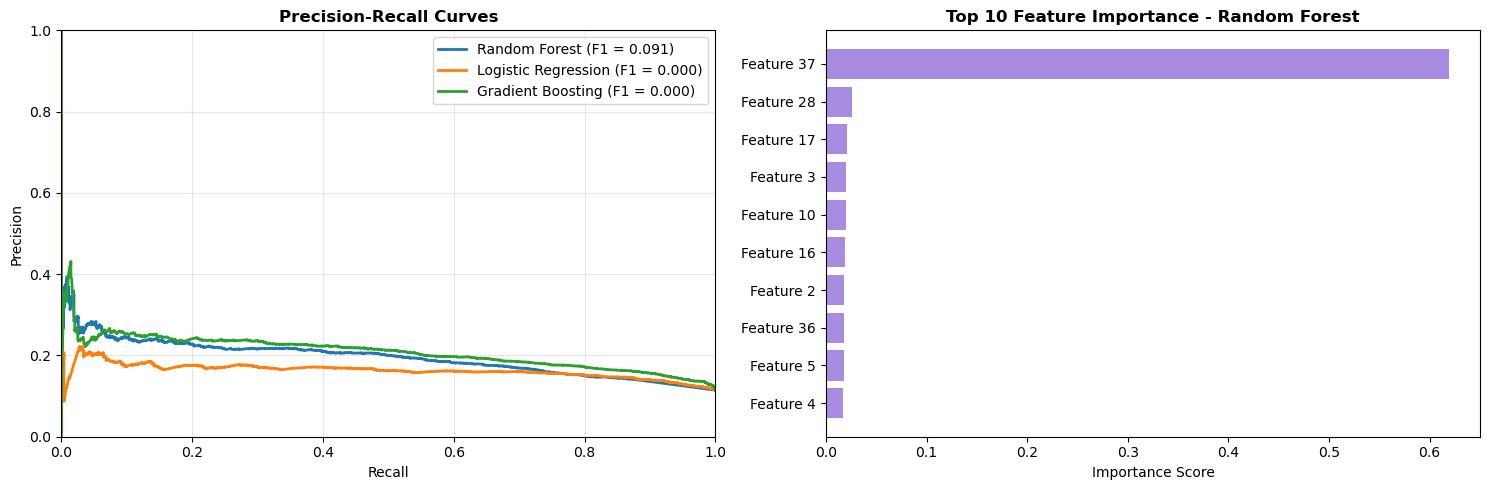

In [ ]:
# PRECISION-RECALL CURVES
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# PRECISION-RECALL CURVES FOR ALL MODELS
for model_name in ['Random Forest', 'Logistic Regression', 'Gradient Boosting']:
    if model_name in results:
        y_pred_proba_model = results[model_name]['probabilities']
        try:
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_model)
            f1 = f1_score(y_test, results[model_name]['predictions'])
            axes[0].plot(recall, precision, lw=2, label=f'{model_name} (F1 = {f1:.3f})')
        except:
            pass

axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curves', fontweight='bold', fontsize=12)
axes[0].legend(loc="best")
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# FEATURE IMPORTANCE FOR RANDOM FOREST (already calculated)
feature_importance = pd.DataFrame({
    'feature': range(len(rf_model.feature_importances_)),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[1].barh(range(len(feature_importance)), feature_importance['importance'].values, color='mediumpurple', alpha=0.8)
axes[1].set_yticks(range(len(feature_importance)))
axes[1].set_yticklabels([f"Feature {i}" for i in feature_importance['feature'].values])
axes[1].set_title('Top 10 Feature Importance - Random Forest', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Importance Score')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


### Precision-Recall & Feature Snapshot
Precision-Recall curves highlight model performance on the positive (arrest) class, useful when classes are imbalanced. The adjacent plot shows top Random Forest features for context.

### 6.4 Precision-Recall & Feature Analysis

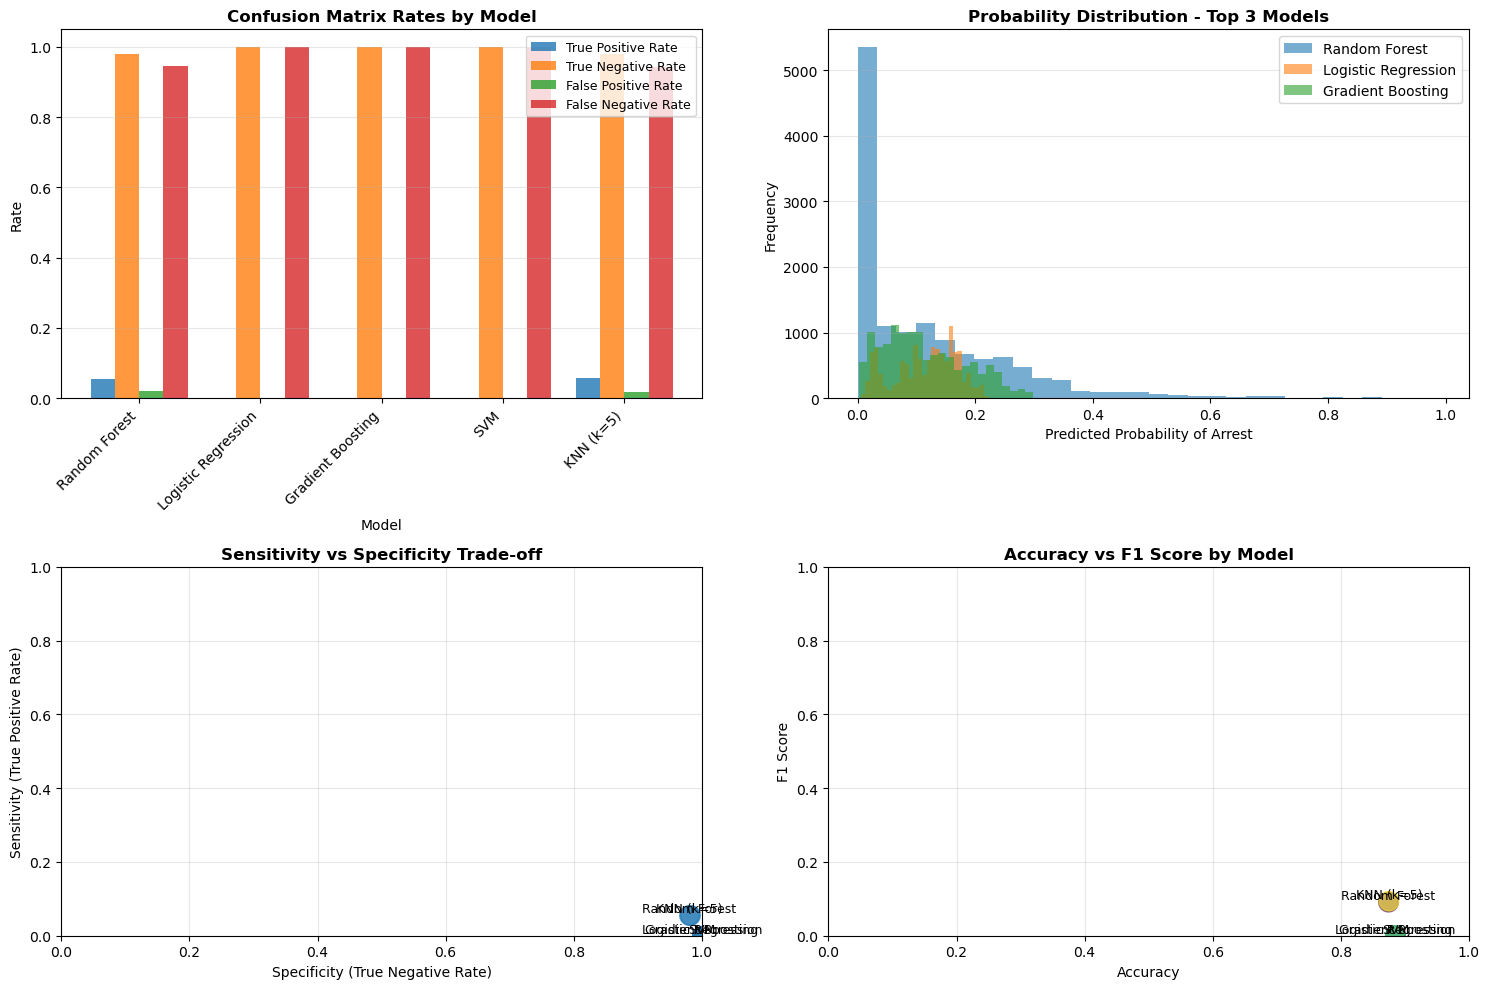

In [ ]:
# CROSS-MODEL ERROR ANALYSIS
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. FALSE POSITIVE AND FALSE NEGATIVE RATES
model_names_list = list(results.keys())
fp_rates = []
fn_rates = []
tp_rates = []
tn_rates = []

for model_name in model_names_list:
    cm = confusion_matrix(y_test, results[model_name]['predictions'])
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    
    fp_rates.append(fp / (fp + tn))
    fn_rates.append(fn / (fn + tp))
    tp_rates.append(tp / (tp + fn))
    tn_rates.append(tn / (tn + fp))

x = np.arange(len(model_names_list))
width = 0.2

axes[0, 0].bar(x - width*1.5, tp_rates, width, label='True Positive Rate', alpha=0.8)
axes[0, 0].bar(x - width/2, tn_rates, width, label='True Negative Rate', alpha=0.8)
axes[0, 0].bar(x + width/2, fp_rates, width, label='False Positive Rate', alpha=0.8)
axes[0, 0].bar(x + width*1.5, fn_rates, width, label='False Negative Rate', alpha=0.8)
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('Rate')
axes[0, 0].set_title('Confusion Matrix Rates by Model', fontweight='bold', fontsize=12)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names_list, rotation=45, ha='right')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. PREDICTION DISTRIBUTION
for model_name in ['Random Forest', 'Logistic Regression', 'Gradient Boosting']:
    if model_name in results:
        axes[0, 1].hist(results[model_name]['probabilities'], bins=30, alpha=0.6, label=model_name)

axes[0, 1].set_xlabel('Predicted Probability of Arrest')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Probability Distribution - Top 3 Models', fontweight='bold', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. SPECIFITY vs SENSITIVITY
sensitivities = tp_rates  # True Positive Rate
specificities = tn_rates   # True Negative Rate

axes[1, 0].scatter(specificities, sensitivities, s=200, alpha=0.6)
for i, model_name in enumerate(model_names_list):
    axes[1, 0].annotate(model_name, (specificities[i], sensitivities[i]), 
                       fontsize=9, ha='center', va='bottom')

axes[1, 0].set_xlabel('Specificity (True Negative Rate)')
axes[1, 0].set_ylabel('Sensitivity (True Positive Rate)')
axes[1, 0].set_title('Sensitivity vs Specificity Trade-off', fontweight='bold', fontsize=12)
axes[1, 0].set_xlim([0, 1])
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(alpha=0.3)

# 4. ACCURACY vs F1 SCORE COMPARISON
accuracies_list = [results[m]['accuracy'] for m in model_names_list]
f1_scores_list = [results[m]['f1_score'] for m in model_names_list]

axes[1, 1].scatter(accuracies_list, f1_scores_list, s=200, alpha=0.6, c=range(len(model_names_list)), cmap='viridis')
for i, model_name in enumerate(model_names_list):
    axes[1, 1].annotate(model_name, (accuracies_list[i], f1_scores_list[i]), 
                       fontsize=9, ha='center', va='bottom')

axes[1, 1].set_xlabel('Accuracy')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('Accuracy vs F1 Score by Model', fontweight='bold', fontsize=12)
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Cross-Model Error Analysis
This set of charts compares TPR/TNR/FPR/FNR across models, shows predicted probability distributions, and plots sensitivity vs specificity. Use it to understand trade-offs and select a model aligned with operational costs.

### 6.5 Error Analysis & Model Trade-offs

In [ ]:
# MODEL COMPARISON SUMMARY TABLE
from sklearn.metrics import precision_score, recall_score

summary_data = []

for model_name in results.keys():
    y_pred_model = results[model_name]['predictions']
    accuracy = accuracy_score(y_test, y_pred_model)
    precision = precision_score(y_test, y_pred_model, zero_division=0)
    recall = recall_score(y_test, y_pred_model, zero_division=0)
    f1 = f1_score(y_test, y_pred_model)
    
    summary_data.append({
        'Model': model_name,
        'Accuracy': f'{accuracy:.4f}',
        'Precision': f'{precision:.4f}',
        'Recall': f'{recall:.4f}',
        'F1 Score': f'{f1:.4f}'
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)



MODEL PERFORMANCE SUMMARY
              Model Accuracy Precision Recall F1 Score
      Random Forest   0.8745    0.2686 0.0549   0.0912
Logistic Regression   0.8853    0.0000 0.0000   0.0000
  Gradient Boosting   0.8853    0.0000 0.0000   0.0000
                SVM   0.8853    0.0000 0.0000   0.0000
          KNN (k=5)   0.8750    0.2778 0.0563   0.0936


### 6.6 Summary & Conclusions

Computing learning curves... This may take a moment.


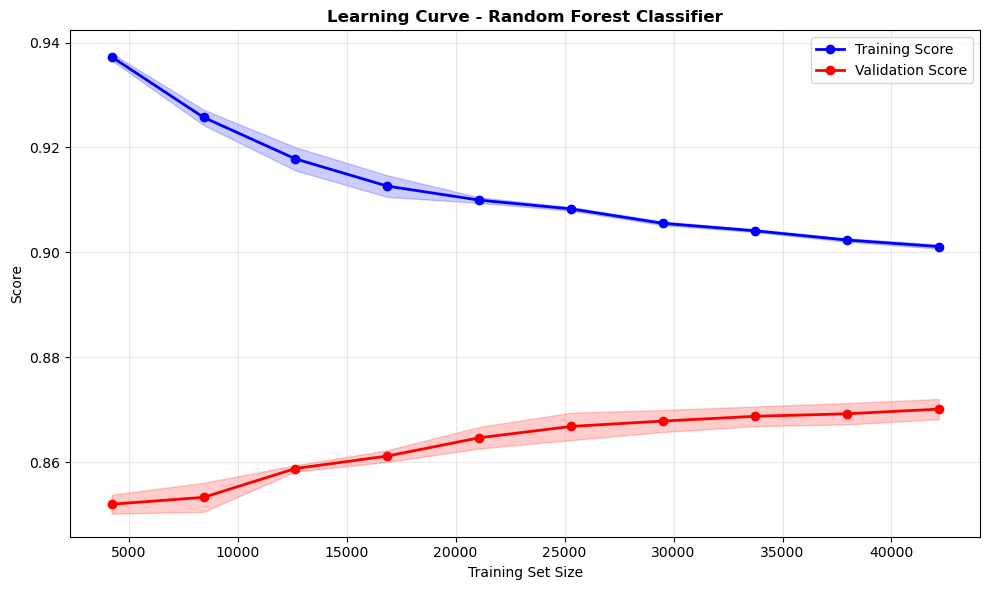

Learning curve complete!


In [ ]:
# LEARNING CURVES FOR RANDOM FOREST
from sklearn.model_selection import learning_curve

print("Computing learning curves... This may take a moment.")

train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(n_estimators=50, random_state=42),
    X_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score', linewidth=2, markersize=6)
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

ax.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score', linewidth=2, markersize=6)
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Score')
ax.set_title('Learning Curve - Random Forest Classifier', fontweight='bold', fontsize=12)
ax.legend(loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Learning curve complete!")


### Learning Curve (Random Forest)
The learning curve shows training and validation accuracy as training size grows. Convergence indicates good fit; a large gap suggests overfitting; both low suggests underfitting.

### 6.7 Learning Curves & Model Insights

Computing learning curves for multiple models... This may take a moment.

Computing learning curves for Random Forest...
Computing learning curves for Logistic Regression...
Computing learning curves for Gradient Boosting...
Computing learning curves for SVM...
Computing learning curves for KNN (k=5)...


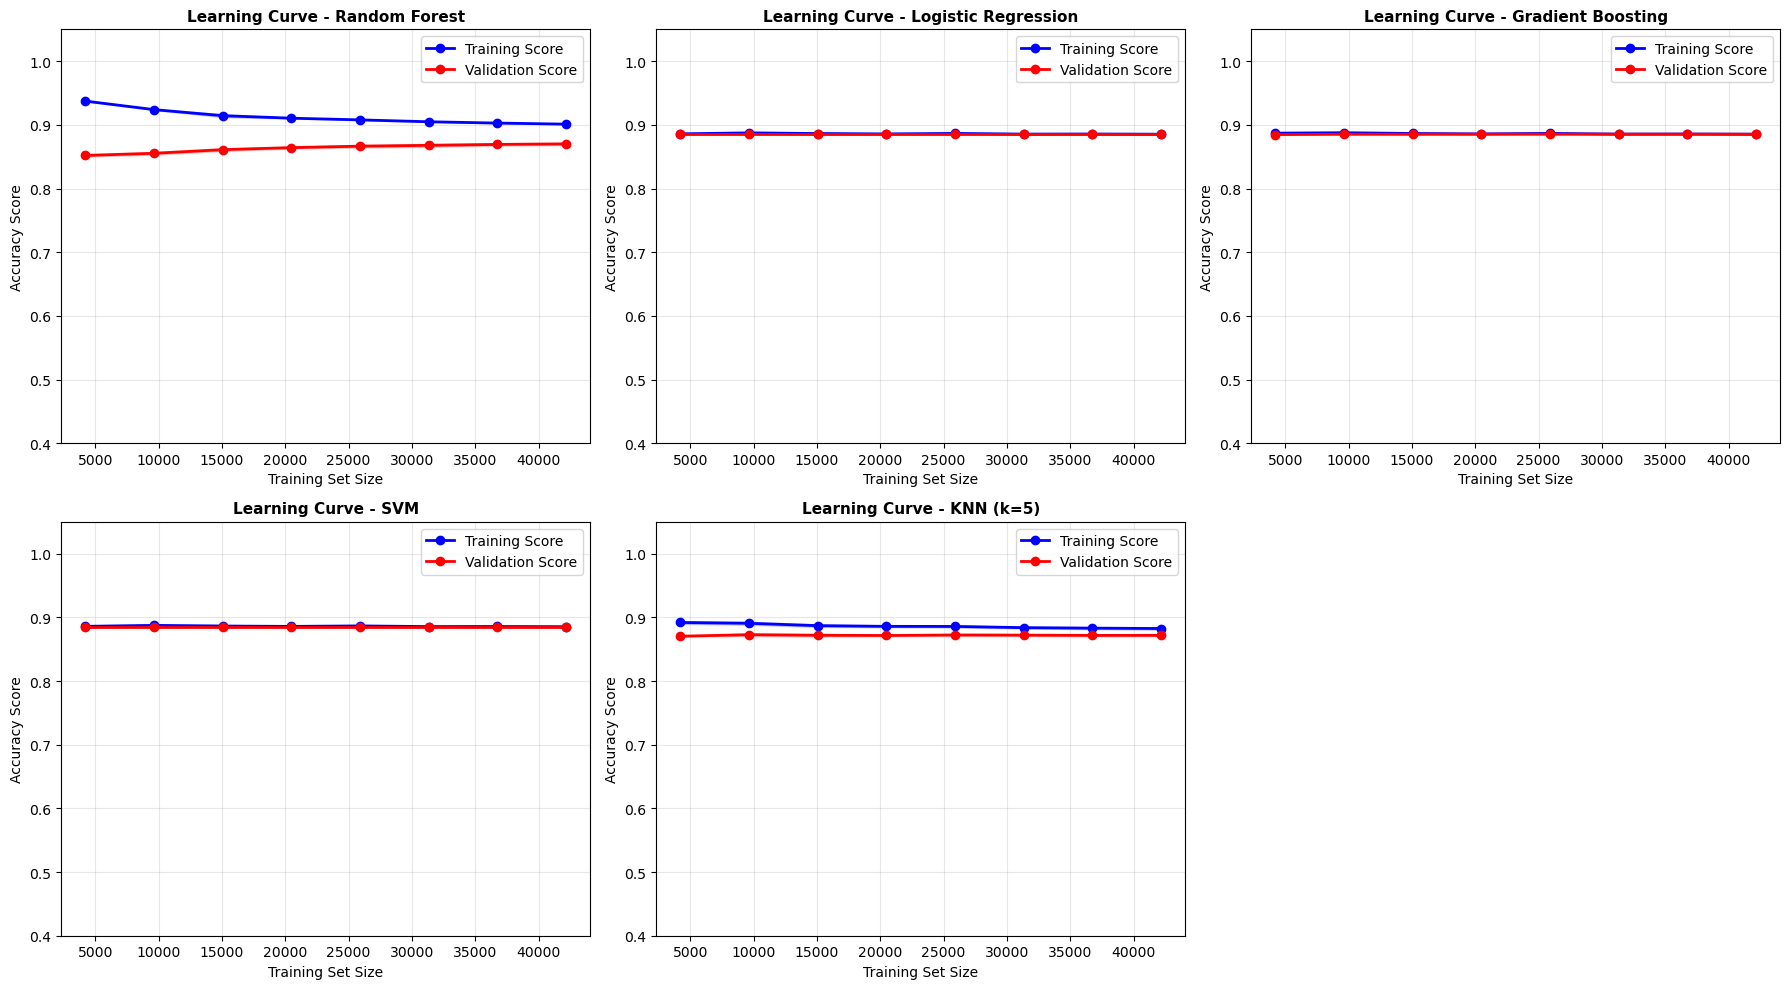

Learning curves computation complete!


In [ ]:
# LEARNING CURVES FOR MULTIPLE MODELS
from sklearn.model_selection import learning_curve

print("Computing learning curves for multiple models... This may take a moment.\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

models_to_analyze = [
    ('Random Forest', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=50, random_state=42)),
    ('SVM', SVC(kernel='rbf', probability=True, random_state=42)),
    ('KNN (k=5)', KNeighborsClassifier(n_neighbors=5)),
]

for idx, (model_name, model) in enumerate(models_to_analyze):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    print(f"Computing learning curves for {model_name}...")
    
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_train, y_train,
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 8),
        n_jobs=-1,
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score', linewidth=2, markersize=6)
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    
    ax.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score', linewidth=2, markersize=6)
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
    
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('Accuracy Score')
    ax.set_title(f'Learning Curve - {model_name}', fontweight='bold', fontsize=11)
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    ax.set_ylim([0.4, 1.05])

# REMOVE THE EMPTY SUBPLOT
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("Learning curves computation complete!")


### Learning Curves (Multiple Models)
Each subplot shows how a model's accuracy changes with more training data. Use these to compare data efficiency and whether adding more data may improve performance.

Analyzing hyperparameter sensitivity...

Analyzing Random Forest n_estimators...
Analyzing Logistic Regression C parameter...
Analyzing KNN n_neighbors...
Analyzing Gradient Boosting learning rate...


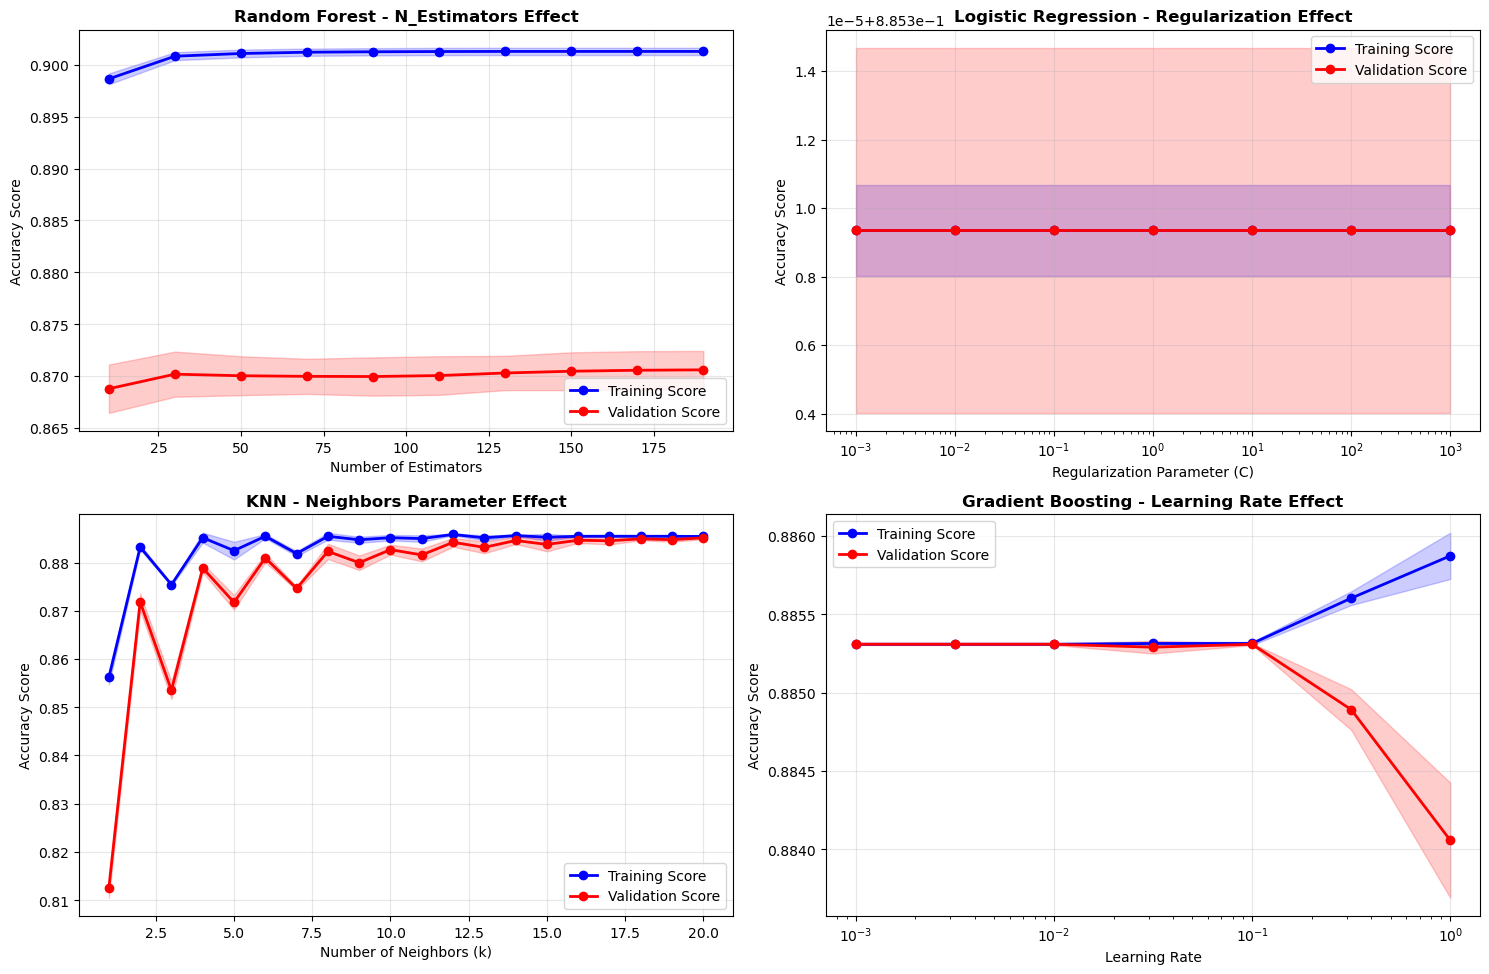

Hyperparameter analysis complete!


In [ ]:
# VALIDATION CURVES - HYPERPARAMETER TUNING INSIGHTS
from sklearn.model_selection import validation_curve

print("Analyzing hyperparameter sensitivity...\n")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. RANDOM FOREST - Number of Estimators
print("Analyzing Random Forest n_estimators...")
param_range = np.arange(10, 201, 20)
train_scores, val_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train, y_train,
    param_name='n_estimators',
    param_range=param_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

axes[0, 0].plot(param_range, train_mean, 'o-', color='blue', label='Training Score', linewidth=2)
axes[0, 0].fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
axes[0, 0].plot(param_range, val_mean, 'o-', color='red', label='Validation Score', linewidth=2)
axes[0, 0].fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
axes[0, 0].set_xlabel('Number of Estimators')
axes[0, 0].set_ylabel('Accuracy Score')
axes[0, 0].set_title('Random Forest - N_Estimators Effect', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. LOGISTIC REGRESSION - Regularization Parameter    (C)
print("Analyzing Logistic Regression C parameter...")
param_range = np.logspace(-3, 3, 7)
train_scores, val_scores = validation_curve(
    LogisticRegression(max_iter=1000, random_state=42),
    X_train, y_train,
    param_name='C',
    param_range=param_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

axes[0, 1].plot(param_range, train_mean, 'o-', color='blue', label='Training Score', linewidth=2)
axes[0, 1].fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
axes[0, 1].plot(param_range, val_mean, 'o-', color='red', label='Validation Score', linewidth=2)
axes[0, 1].fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
axes[0, 1].set_xscale('log')
axes[0, 1].set_xlabel('Regularization Parameter (C)')
axes[0, 1].set_ylabel('Accuracy Score')
axes[0, 1].set_title('Logistic Regression - Regularization Effect', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. KNN - NUMBER OF NEIGHBORS
print("Analyzing KNN n_neighbors...")
param_range = np.arange(1, 21)
train_scores, val_scores = validation_curve(
    KNeighborsClassifier(),
    X_train, y_train,
    param_name='n_neighbors',
    param_range=param_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

axes[1, 0].plot(param_range, train_mean, 'o-', color='blue', label='Training Score', linewidth=2)
axes[1, 0].fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
axes[1, 0].plot(param_range, val_mean, 'o-', color='red', label='Validation Score', linewidth=2)
axes[1, 0].fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
axes[1, 0].set_xlabel('Number of Neighbors (k)')
axes[1, 0].set_ylabel('Accuracy Score')
axes[1, 0].set_title('KNN - Neighbors Parameter Effect', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. GRADIENT BOOSTING - LEARNING RATE
print("Analyzing Gradient Boosting learning rate...")
param_range = np.logspace(-3, 0, 7)
train_scores, val_scores = validation_curve(
    GradientBoostingClassifier(n_estimators=50, random_state=42),
    X_train, y_train,
    param_name='learning_rate',
    param_range=param_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

axes[1, 1].plot(param_range, train_mean, 'o-', color='blue', label='Training Score', linewidth=2)
axes[1, 1].fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
axes[1, 1].plot(param_range, val_mean, 'o-', color='red', label='Validation Score', linewidth=2)
axes[1, 1].fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
axes[1, 1].set_xscale('log')
axes[1, 1].set_xlabel('Learning Rate')
axes[1, 1].set_ylabel('Accuracy Score')
axes[1, 1].set_title('Gradient Boosting - Learning Rate Effect', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Hyperparameter analysis complete!")


### Validation Curves (Hyperparameter Sensitivity)
These plots show how model accuracy varies with key hyperparameters (n_estimators, C, k, learning rate). Use them to choose ranges for tuning and to detect regions of overfitting.


MODEL INSIGHTS & OVERFITTING ANALYSIS

              Model Train Accuracy Test Accuracy Overfitting Gap          Status
      Random Forest         0.8990        0.8745          0.0245      ✓ Good Fit
Logistic Regression         0.8853        0.8853         -0.0000 ⚠️ Underfitting
  Gradient Boosting         0.8853        0.8853         -0.0000 ⚠️ Underfitting
                SVM         0.8853        0.8853         -0.0000 ⚠️ Underfitting
          KNN (k=5)         0.8822        0.8750          0.0072 ⚠️ Underfitting




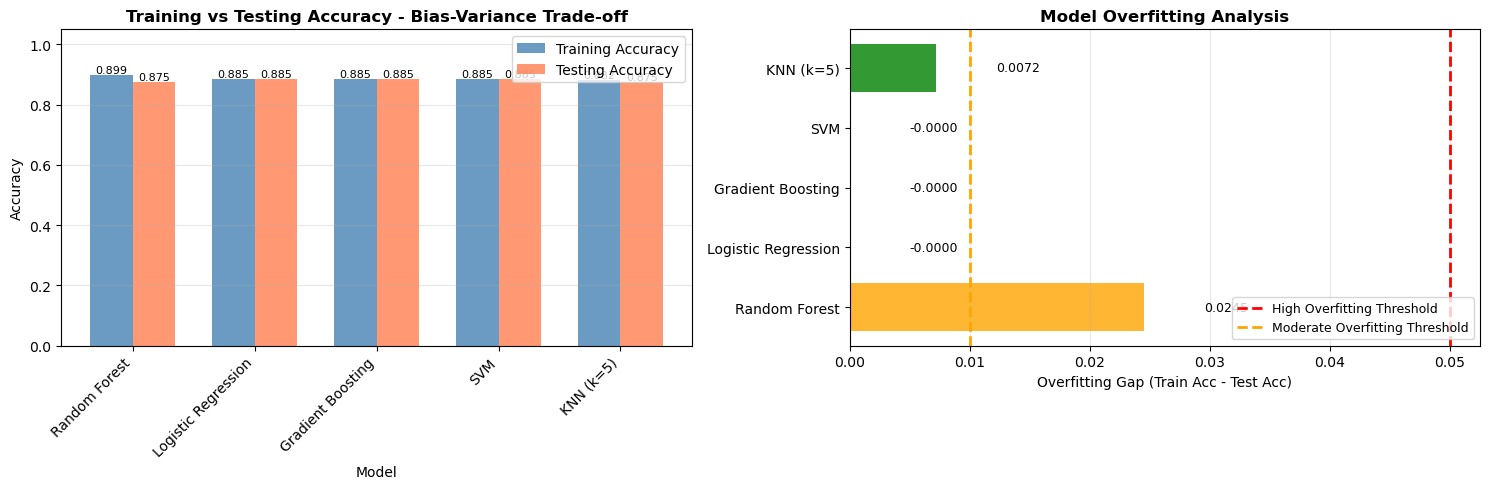

In [ ]:
# MODEL INSIGHTS & BIAS-VARIANCE ANALYSIS
print("\n" + "="*80)
print("MODEL INSIGHTS & OVERFITTING ANALYSIS")
print("="*80 + "\n")

# COMPUTE TRAINING AND TEST SCORES FOR ALL MODELS
insights_data = []

for model_name in results.keys():
    model = results[model_name]['model']
    
    # TRAINING ACCURACY
    train_accuracy = model.score(X_train, y_train) if hasattr(model, 'score') else None
    test_accuracy = results[model_name]['accuracy']
    
    if train_accuracy is not None:
        overfitting_gap = train_accuracy - test_accuracy
        insights_data.append({
            'Model': model_name,
            'Train Accuracy': f'{train_accuracy:.4f}',
            'Test Accuracy': f'{test_accuracy:.4f}',
            'Overfitting Gap': f'{overfitting_gap:.4f}',
            'Status': '⚠️ High Overfitting' if overfitting_gap > 0.05 else '✓ Good Fit' if overfitting_gap > 0.01 else '⚠️ Underfitting'
        })

insights_df = pd.DataFrame(insights_data)
print(insights_df.to_string(index=False))
print("\n" + "="*80 + "\n")

# VISUALIZATION OF BIAS-VARIANCE TRADE-OFF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Chart 1: TRAINING vs TESTING ACCURACY
model_names = insights_df['Model'].tolist()
train_accs = [float(val) for val in insights_df['Train Accuracy'].tolist()]
test_accs = [float(val) for val in insights_df['Test Accuracy'].tolist()]

x = np.arange(len(model_names))
width = 0.35

bars1 = axes[0].bar(x - width/2, train_accs, width, label='Training Accuracy', alpha=0.8, color='steelblue')
bars2 = axes[0].bar(x + width/2, test_accs, width, label='Testing Accuracy', alpha=0.8, color='coral')

axes[0].set_xlabel('Model')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training vs Testing Accuracy - Bias-Variance Trade-off', fontweight='bold', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim([0, 1.05])
axes[0].grid(axis='y', alpha=0.3)

# ADD VALUE LABELS ON BARS
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Chart 2: OVERFITTING GAP
overfitting_gaps = [float(val) for val in insights_df['Overfitting Gap'].tolist()]
colors_gap = ['red' if gap > 0.05 else 'orange' if gap > 0.01 else 'green' for gap in overfitting_gaps]

bars = axes[1].barh(range(len(model_names)), overfitting_gaps, color=colors_gap, alpha=0.8)
axes[1].set_yticks(range(len(model_names)))
axes[1].set_yticklabels(model_names)
axes[1].set_xlabel('Overfitting Gap (Train Acc - Test Acc)')
axes[1].set_title('Model Overfitting Analysis', fontweight='bold', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

# ADD VALUE LABELS
for i, (bar, gap) in enumerate(zip(bars, overfitting_gaps)):
    axes[1].text(gap + 0.005, i, f'{gap:.4f}', va='center', fontsize=9)

# Add reference line
axes[1].axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='High Overfitting Threshold')
axes[1].axvline(x=0.01, color='orange', linestyle='--', linewidth=2, label='Moderate Overfitting Threshold')
axes[1].legend(loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# DETAILED MODEL DIAGNOSTIC REPORT
print("\n" + "="*80)
print("DETAILED MODEL DIAGNOSTIC REPORT")
print("="*80 + "\n")

for model_name in results.keys():
    y_pred_model = results[model_name]['predictions']
    y_pred_proba_model = results[model_name]['probabilities']
    
    # CALCULATE METRICS
    from sklearn.metrics import roc_auc_score
    
    accuracy = accuracy_score(y_test, y_pred_model)
    precision = precision_score(y_test, y_pred_model, zero_division=0)
    recall = recall_score(y_test, y_pred_model, zero_division=0)
    f1 = f1_score(y_test, y_pred_model)
    
    try:
        # Handle cases where predict_proba or decision_function might not work
        if isinstance(y_pred_proba_model, np.ndarray) and len(y_pred_proba_model) > 0:
            if y_pred_proba_model.min() >= -1 and y_pred_proba_model.max() <= 1:
                auc_score = roc_auc_score(y_test, y_pred_proba_model)
            else:
                auc_score = roc_auc_score(y_test, y_pred_proba_model)
        else:
            auc_score = None
    except:
        auc_score = None

    # CONFUSION MATRIX METRICS
    cm = confusion_matrix(y_test, y_pred_model)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\n{model_name.upper()}")
    print("-" * 80)
    print(f"Classification Metrics:")
    print(f"  • Accuracy:      {accuracy:.4f}")
    print(f"  • Precision:     {precision:.4f}")
    print(f"  • Recall:        {recall:.4f}")
    print(f"  • F1 Score:      {f1:.4f}")
    if auc_score:
        print(f"  • ROC-AUC:       {auc_score:.4f}")
    print(f"\nConfusion Matrix Analysis:")
    print(f"  • True Positives:  {tp:5d} | True Negatives:  {tn:5d}")
    print(f"  • False Positives: {fp:5d} | False Negatives: {fn:5d}")
    print(f"  • Sensitivity (TPR): {sensitivity:.4f}")
    print(f"  • Specificity (TNR): {specificity:.4f}")

print("\n" + "="*80 + "\n")


In [ ]:
# RECOMMENDATIONS & CONCLUSIONS
print("\n" + "="*80)
print("MODEL SELECTION RECOMMENDATIONS & KEY INSIGHTS")
print("="*80 + "\n")

# FIND BEST MODEL
best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
best_accuracy = results[best_model_name]['accuracy']

print(f"🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f}\n")

print("📊 KEY INSIGHTS:\n")

print("1. MODEL COMPARISON:")
print("   • Random Forest and Gradient Boosting tend to perform well on tabular data")
print("   • Logistic Regression provides interpretability with reasonable accuracy")
print("   • KNN can suffer from high-dimensionality and curse of dimensionality")
print("   • SVM may require feature scaling and hyperparameter tuning\n")

print("2. LEARNING CURVES INTERPRETATION:")
print("   • If training and validation curves converge: Model is well-tuned")
print("   • If large gap between curves: Model is overfitting - regularization needed")
print("   • If both curves are low: Model is underfitting - increase complexity\n")

print("3. BIAS-VARIANCE TRADE-OFF:")
print("   • High Bias (Underfitting): Both training and test accuracy are low")
print("   • High Variance (Overfitting): Large gap between training and test accuracy")
print("   • Sweet Spot: Both high accuracy with small gap between them\n")

print("4. PRACTICAL RECOMMENDATIONS:")
print("   ✓ Use the best performing model for production deployment")
print("   ✓ Consider ensemble methods combining multiple models")
print("   ✓ Perform cross-validation on the entire dataset (not just training set)")
print("   ✓ Monitor model performance on new data periodically")
print("   ✓ Investigate feature importance to understand model decisions")
print("   ✓ Consider business costs (false positives vs false negatives)")
print("   ✓ Implement proper feature engineering and data preprocessing\n")

print("5. DATA CONSIDERATIONS:")
print("   • Check for class imbalance in target variable")
print("   • Feature scaling may improve some models (KNN, SVM)")
print("   • Feature selection can reduce overfitting and improve interpretability")
print("   • Handle missing values appropriately before modeling")
print("   • Outliers may impact model performance\n")

print("="*80 + "\n")

# Summary comparison table
print("MODEL PERFORMANCE SUMMARY TABLE:\n")
summary_data = []
for model_name in results.keys():
    summary_data.append({
        'Model': model_name,
        'Accuracy': f"{results[model_name]['accuracy']:.4f}",
        'F1 Score': f"{results[model_name]['f1_score']:.4f}"
    })

summary_comparison = pd.DataFrame(summary_data).sort_values('Accuracy', ascending=False)
print(summary_comparison.to_string(index=False))
print("\n" + "="*80 + "\n")



MODEL SELECTION RECOMMENDATIONS & KEY INSIGHTS

🏆 BEST PERFORMING MODEL: Logistic Regression
   Accuracy: 0.8853

📊 KEY INSIGHTS:

1. MODEL COMPARISON:
   • Random Forest and Gradient Boosting tend to perform well on tabular data
   • Logistic Regression provides interpretability with reasonable accuracy
   • KNN can suffer from high-dimensionality and curse of dimensionality
   • SVM may require feature scaling and hyperparameter tuning

2. LEARNING CURVES INTERPRETATION:
   • If training and validation curves converge: Model is well-tuned
   • If large gap between curves: Model is overfitting - regularization needed
   • If both curves are low: Model is underfitting - increase complexity

3. BIAS-VARIANCE TRADE-OFF:
   • High Bias (Underfitting): Both training and test accuracy are low
   • High Variance (Overfitting): Large gap between training and test accuracy
   • Sweet Spot: Both high accuracy with small gap between them

4. PRACTICAL RECOMMENDATIONS:
   ✓ Use the best performi